In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from scipy.signal import periodogram

# For Bayesian modeling
import pymc as pm
import arviz as az

# For datetime manipulation
from datetime import datetime

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


C:\Users\Time27.B1729\AppData\Local\Temp\ipykernel_21940\1265307592.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


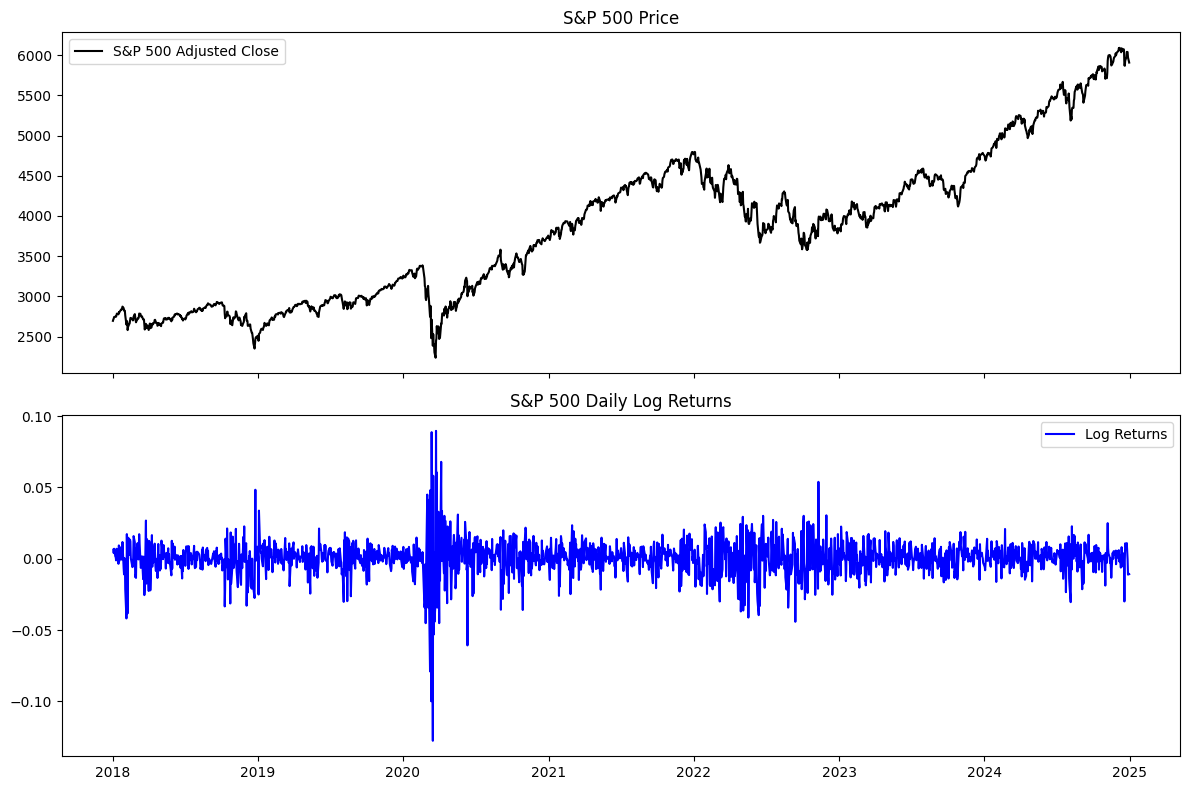

In [3]:
# Download S&P 500 daily closing prices for past 5 years
sp500 = yf.download("^GSPC", start="2018-01-01", end="2024-12-31")
sp500 = sp500["Close"].dropna()

# Compute log returns
log_returns = np.log(sp500 / sp500.shift(1)).dropna()

# Plot prices and returns
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs[0].plot(sp500, label="S&P 500 Adjusted Close", color='black')
axs[0].set_title("S&P 500 Price")
axs[0].legend()

axs[1].plot(log_returns, label="Log Returns", color='blue')
axs[1].set_title("S&P 500 Daily Log Returns")
axs[1].legend()

plt.tight_layout()
plt.show()

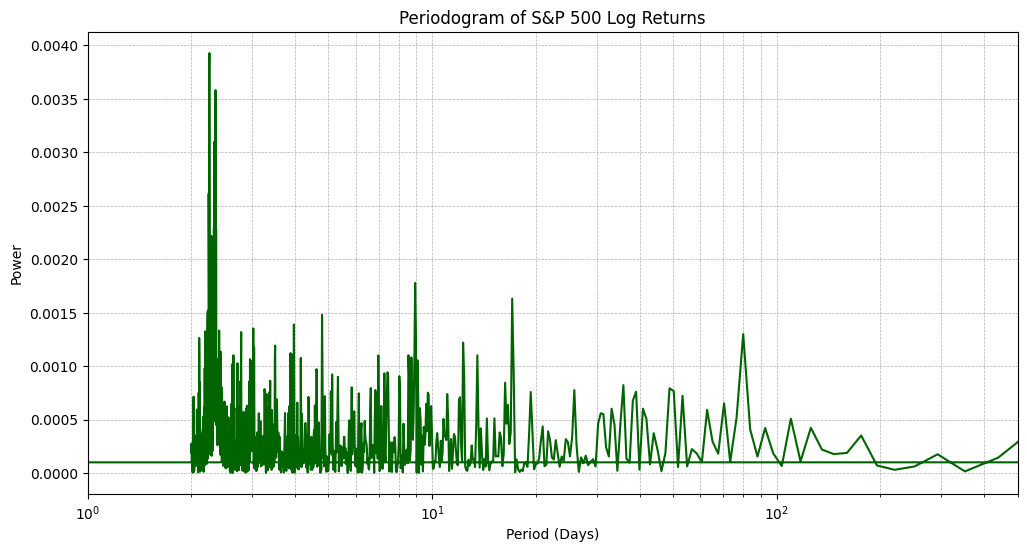

In [6]:
from scipy.signal import periodogram

# Convert returns to numpy array
returns_array = np.ravel(log_returns.values)
fs = 1  # Sampling frequency: 1/day

# Compute periodogram
frequencies, power = periodogram(returns_array, fs=fs, scaling='density', window='hann')

# Convert frequency to periods (in days)
with np.errstate(divide='ignore'):
    periods = 1 / frequencies
    periods[~np.isfinite(periods)] = 0  # Avoid division-by-zero for freq=0

# Plot
plt.figure(figsize=(12, 6))
plt.plot(periods, power, color='darkgreen')
plt.xlabel("Period (Days)")
plt.ylabel("Power")
plt.title("Periodogram of S&P 500 Log Returns")
plt.xscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(1, 500)
plt.show()

Let’s begin with a **Bayesian sinusoidal + noise model** to build intuition.

We shall model: <br>
<center> $ y_t = A.\sin(\frac{2\pi t}{P} + \phi) + \epsilon_t, $  &nbsp;  $ \epsilon_t \sim \mathcal{N}(0, \sigma^2) $ </center>

where, 
* $y_t$ = Observed log returns;
* $A$ = Amplitude;
* $P$ = Period;
* $\phi$ = Phase shift;
* $\sigma$ = Noise standard deviation.